In [ ]:
import kagglehub

path = kagglehub.dataset_download("kimbosoek/cosmos-images")

print("Path to dataset files:", path)

100%|██████████| 104M/104M [00:01<00:00, 76.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kimbosoek/cosmos-images/versions/1


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
import glob

In [ ]:
image_dir = os.path.join(path, "data/img_align_celeba")

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 25
LATENT_DIM = 128
N_CRITIC = 5
LAMBDA_GP = 10
LR = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataset Class

In [ ]:
class CosmosDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

Data Transforms and DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = CosmosDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Total images: {len(dataset)}")

Total images: 3612


Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=3):
        super(Generator, self).__init__()

        self.init_size = IMG_SIZE // 16
        self.fc = nn.Linear(latent_dim, 512 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Critic Network

In [ ]:
class Critic(nn.Module):
    def __init__(self, img_channels=3):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, stride=2, padding=1)
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1)

Gradient Penalty Function

In [ ]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

In [ ]:
generator = Generator(LATENT_DIM).to(device)
critic = Critic().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.0, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))

print("Generator parameters:", sum(p.numel() for p in generator.parameters()))
print("Critic parameters:", sum(p.numel() for p in critic.parameters()))

Generator parameters: 5779459
Critic parameters: 2766529


In [ ]:
os.makedirs("generated_images", exist_ok=True)
fixed_noise = torch.randn(16, LATENT_DIM, device=device)

for epoch in range(EPOCHS):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Critic
        for _ in range(N_CRITIC):
            optimizer_C.zero_grad()

            z = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_imgs = generator(z).detach()

            real_validity = critic(real_imgs)
            fake_validity = critic(fake_imgs)

            gradient_penalty = compute_gradient_penalty(critic, real_imgs, fake_imgs, device)

            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty

            c_loss.backward()
            optimizer_C.step()

        # Train Generator
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_imgs = generator(z)
        fake_validity = critic(fake_imgs)

        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                  f"[C loss: {c_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    with torch.no_grad():
        fake_imgs = generator(fixed_noise)
        grid = make_grid(fake_imgs, nrow=4, normalize=True)
        save_image(grid, f"generated_images/epoch_{epoch}.png")

[Epoch 0/25] [Batch 0/113] [C loss: 147.6342] [G loss: -0.0046]
[Epoch 0/25] [Batch 100/113] [C loss: -0.7306] [G loss: 0.2420]
[Epoch 1/25] [Batch 0/113] [C loss: -1.0651] [G loss: 0.7683]
[Epoch 1/25] [Batch 100/113] [C loss: -0.3288] [G loss: 1.0378]
[Epoch 2/25] [Batch 0/113] [C loss: -0.9780] [G loss: 2.1842]
[Epoch 2/25] [Batch 100/113] [C loss: -1.0904] [G loss: 1.2880]
[Epoch 3/25] [Batch 0/113] [C loss: -1.0454] [G loss: 1.1517]
[Epoch 3/25] [Batch 100/113] [C loss: -0.7164] [G loss: 1.2242]
[Epoch 4/25] [Batch 0/113] [C loss: -1.1060] [G loss: 1.9630]
[Epoch 4/25] [Batch 100/113] [C loss: -1.0365] [G loss: 1.2101]
[Epoch 5/25] [Batch 0/113] [C loss: -0.8888] [G loss: 1.5066]
[Epoch 5/25] [Batch 100/113] [C loss: -0.8677] [G loss: 2.0968]
[Epoch 6/25] [Batch 0/113] [C loss: -0.7984] [G loss: 1.8987]
[Epoch 6/25] [Batch 100/113] [C loss: -0.9203] [G loss: 2.5360]
[Epoch 7/25] [Batch 0/113] [C loss: -0.9047] [G loss: 1.6909]
[Epoch 7/25] [Batch 100/113] [C loss: -0.9743] [G loss

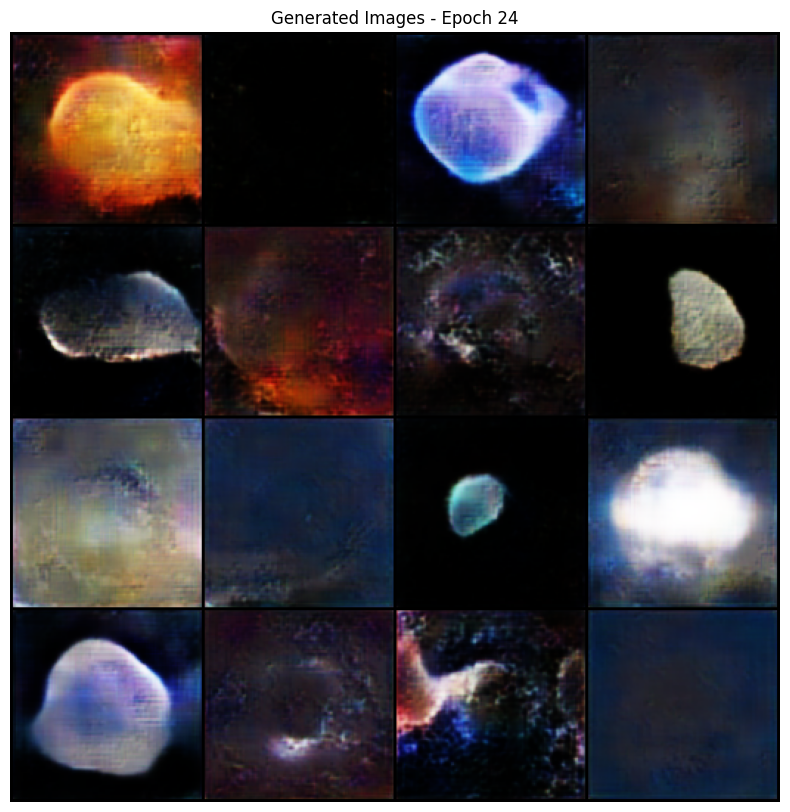

In [ ]:
def show_generated_images(epoch):
    img = Image.open(f"generated_images/epoch_{epoch}.png")
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Generated Images - Epoch {epoch}')
    plt.show()

show_generated_images(EPOCHS-1)

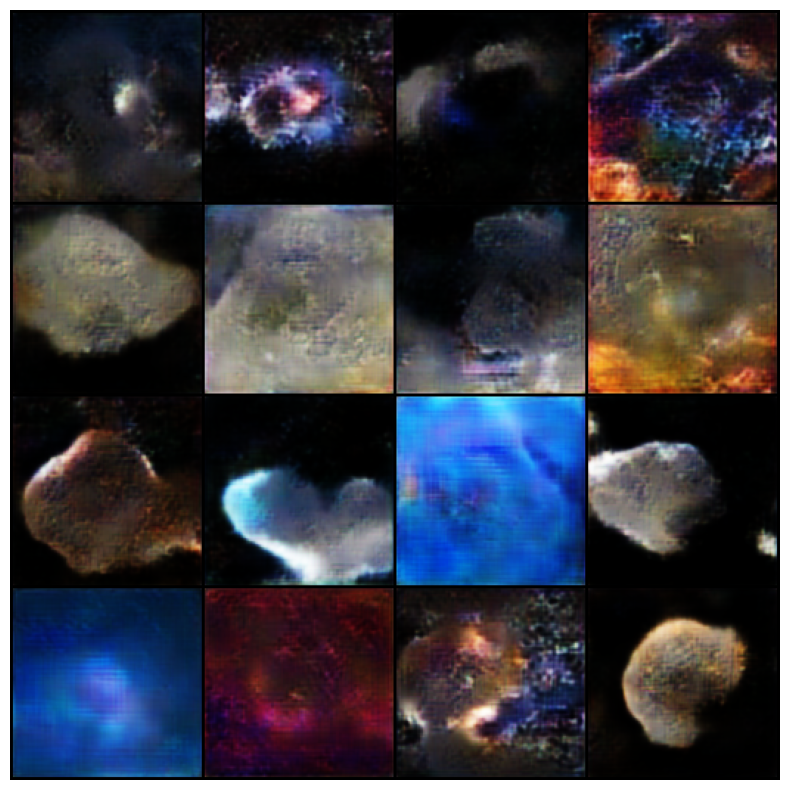

In [ ]:
def generate_images(num_images=16):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, LATENT_DIM, device=device)
        generated_imgs = generator(z)
        grid = make_grid(generated_imgs, nrow=4, normalize=True)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    return generated_imgs

generated_imgs = generate_images(16)